In [17]:
from __future__ import print_function

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np
import math
import json

with open('./data.json', 'r') as data_file:
    apps = np.array(json.load(data_file))

In [10]:
limit = 500
n_init = 30

# Separate the reviews based on rating
reviews_5 = [review for app in apps for review in app['reviews'] if review['rating'] == '5']
reviews_4 = [review for app in apps for review in app['reviews'] if review['rating'] == '4']
reviews_3 = [review for app in apps for review in app['reviews'] if review['rating'] == '3']
reviews_2 = [review for app in apps for review in app['reviews'] if review['rating'] == '2']
reviews_1 = [review for app in apps for review in app['reviews'] if review['rating'] == '1']

# Shuffle the rating-based reviews in order to randomize picking
shuffle(reviews_5)
shuffle(reviews_4)
shuffle(reviews_3)
shuffle(reviews_2)
shuffle(reviews_1)

# Pick the top <limit> reviews for each rating
reviews = []
reviews.extend(reviews_5[:limit])
reviews.extend(reviews_4[:limit])
reviews.extend(reviews_3[:limit])
reviews.extend(reviews_2[:limit])
reviews.extend(reviews_1[:limit])

# Shuffle all picked reviews to present model with randomized data
shuffle(reviews)

# Create the hold out set
hold_out_percentage = .20
hold_out_start = int(len(reviews) - (len(reviews) * hold_out_percentage))
hold_out_reviews = [review['content'] for review in reviews[hold_out_start:]]

# Extract the necessary information for our dataset and corresponding labels
train_reviews = reviews[:hold_out_start]
dataset = np.array([review['content'] for review in train_reviews])
labels = np.array([int(review['rating']) for review in train_reviews])

# Transforms the text dataset into a set of vectors based on TF-IDF algorithm
# TF: Term Frequency
# IDF: Inverse Document Frequence
# TF-IDF = (1 + log(# Times Term Appears in Documents)) * log(# Documents/# Times t appears in Documents)
# Score Increases with Rarity in all documents
# Score Increases with Frequency in a document containing it

# Train the feature extractor
vectorizer = TfidfVectorizer(
    min_df=0.02,
    max_df=0.8, 
    max_features=10000, 
    stop_words='english', 
    use_idf=True
)
X = vectorizer.fit_transform(dataset)

## Find Optimal Sigma

Sigma Result: (0.10000000000000001, -24661.021460683965)
Sigma Result: (0.15000000000000002, -16343.185166733545)
Sigma Result: (0.20000000000000004, -17942.25517864393)
Sigma Result: (0.25000000000000006, -21507.21532842677)
Sigma Result: (0.30000000000000004, -25304.67594883528)
Sigma Result: (0.35000000000000009, -28898.602284212502)
Sigma Result: (0.40000000000000013, -32271.072998118805)
Sigma Result: (0.45000000000000007, -35361.93687504077)
Sigma Result: (0.50000000000000011, -38195.50588166667)
Sigma Result: (0.55000000000000016, -40857.0057339631)
Sigma Result: (0.6000000000000002, -43323.34356442709)
Sigma Result: (0.65000000000000013, -45626.14828165582)
Sigma Result: (0.70000000000000018, -47790.70894497598)
Sigma Result: (0.75000000000000022, -49824.66188970828)
Sigma Result: (0.80000000000000016, -51724.700209204144)
Sigma Result: (0.8500000000000002, -53537.73598067562)
Sigma Result: (0.90000000000000024, -55260.42990656348)
Sigma Result: (0.95000000000000029, -56892.409

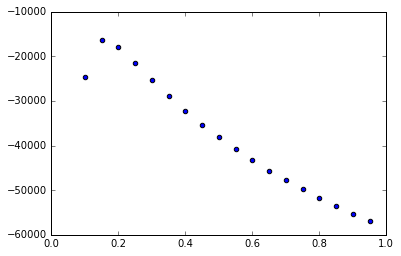

In [11]:
%matplotlib inline

# Fix number of clusters and iterate over sigmas to find best log likelihood
default_k = 20
sigma_results = []

for sigma in np.arange(.1, 1.0, .05):
    kmeans = KMeans(init='k-means++', n_clusters=default_k, n_init=n_init)
    kmeans.fit(X)

    centroids = kmeans.cluster_centers_

    log_likehood_hold_out = 0

    for h in hold_out_reviews:
        transformed_test_review = vectorizer.transform([h])

        norm_dist_sum = 0

        for centroid in centroids:
            dist = euclidean(transformed_test_review.todense(), centroid)
            norm_dist = math.exp((-1/2) * math.pow(abs(dist), 2) / math.pow(sigma, 2))
            norm_dist_sum += norm_dist

        log_likehood_hold_out += math.log(norm_dist_sum)

    l2 = len(hold_out_reviews) * ((X.shape[1] / 2) * math.log(2 * math.pi * sigma) + math.log(default_k))
    log_likehood_hold_out -= l2

    print ('Sigma Result: ' + str((sigma, log_likehood_hold_out)))
    sigma_results.append([sigma, log_likehood_hold_out])
    
opt_sigma = max([sr[1] for sr in sigma_results])
optimal_sigma = sigma_results[list(np.array(sigma_results)[:, 1]).index(opt_sigma)][0]
print('Optimal Sigma: ' + str(optimal_sigma))

plt.scatter([sr[0] for sr in sigma_results], [sr[1] for sr in sigma_results])
plt.show()

## Find Optimal K

K Result: (20, -16377.839338833846)
K Result: (30, -15917.444809654626)
K Result: (40, -15232.53812176556)
K Result: (50, -14973.711843553763)
K Result: (60, -14677.226305419752)
K Result: (70, -14328.789172280758)
K Result: (80, -14100.5782393365)
K Result: (90, -14091.919175854826)
K Result: (100, -14048.297216812218)
K Result: (110, -13822.683479849571)
K Result: (120, -13697.65823755506)
K Result: (130, -13887.392554243135)
K Result: (140, -13746.322466822616)
K Result: (150, -13654.300893490763)
K Result: (160, -13743.579524882249)
K Result: (170, -13660.482194923276)
K Result: (180, -13723.065223280511)
K Result: (190, -13612.60833644182)
K Result: (200, -13675.761811839344)
K Result: (210, -13567.778202471482)
K Result: (220, -13720.064761204998)
K Result: (230, -13715.465293151858)
K Result: (240, -13735.680936471786)
Optimal K: 210


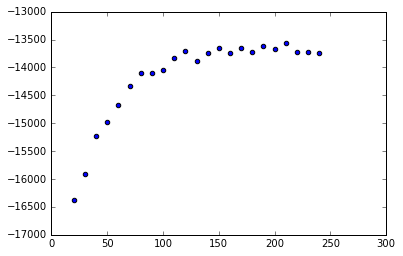

In [15]:
%matplotlib inline

k_results = []

for k in np.arange(20, 250, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=n_init)
    kmeans.fit(X)

    log_likehood_hold_out = 0

    for h in hold_out_reviews:
        transformed_test_review = vectorizer.transform([h])

        norm_dist_sum = 0

        centroids = kmeans.cluster_centers_
        
        for centroid in centroids:
            dist = euclidean(transformed_test_review.todense(), centroid)
            norm_dist = math.exp((-1/2) * math.pow(abs(dist), 2) / math.pow(optimal_sigma, 2))
            norm_dist_sum += norm_dist

        log_likehood_hold_out += math.log(norm_dist_sum)

    l2 = len(hold_out_reviews) * ((X.shape[1] / 2) * math.log(2 * math.pi * optimal_sigma) + math.log(k))
    log_likehood_hold_out -= l2

    print ('K Result: ' + str((k, log_likehood_hold_out)))
    k_results.append([k, log_likehood_hold_out])
    
opt_k = max([kr[1] for kr in k_results])
optimal_k = k_results[list(np.array(k_results)[:, 1]).index(opt_k)][0]
print('Optimal K: ' + str(optimal_k))

plt.scatter([kr[0] for kr in k_results], [kr[1] for kr in k_results])
plt.show()

In [19]:
# Change optimal_k here and in following sections to match best true k, not 
# an anomoly best k that may have been predicted above

defined_k = None
assigned_k = optimal_k if not defined_k else defined_k

kmeans = KMeans(init='k-means++', n_clusters=optimal_k, n_init=n_init)
kmeans.fit(X)

initial_centroids = kmeans.cluster_centers_

print('Top terms per cluster:')
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

terms_per_cluster = 10

for i in range(assigned_k):
    print('Cluster %d:' % i, end='')
    for ind in order_centroids[i, :terms_per_cluster]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: best prices pretty check things items app got having great
Cluster 1: love best new work got good things store app like
Cluster 2: buy love app use easy items doesn know looking stores
Cluster 3: takes open fix app phone screen shipping stuff buy time
Cluster 4: good app just products clothes like stuff shopping think great
Cluster 5: crashing update new awesome won need let app make place
Cluster 6: able app like shop use add page items view love
Cluster 7: cart shopping save purchase items option look time app apps
Cluster 8: thing item app like make love view bag way want
Cluster 9: keeps fix app works load says bag clothes shopping love
Cluster 10: products great website app shipping bought long times quality love
Cluster 11: favorite store best express app way wish bag thing able
Cluster 12: wish list add app needs clothes love makes fix things
Cluster 13: ve customer reviews people phone like item things really use
Cluster 14: works app love fix 

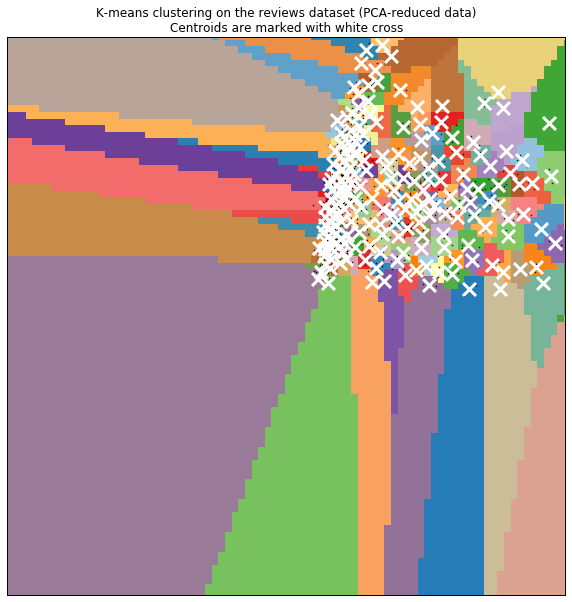

In [20]:
%matplotlib inline

def graph_kmeans(data, k):
    reduced_data = PCA(n_components=2).fit_transform(data)
    
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=n_init)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the reviews dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(-1.07897615691, 0.59240174288)
    plt.ylim(-1.19929985738, 0.49430449705)
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
graph_kmeans(X.toarray(), assigned_k)

In [28]:
limited_reviews_1 = np.array([review['content'] for review in reviews_1[:limit]])
transformed_reviews_1 = vectorizer.transform(limited_reviews_1)

kmeans = KMeans(init='k-means++', n_clusters=assigned_k, n_init=n_init)
kmeans.fit(X)
predicted = kmeans.predict(transformed_reviews_1)

most_negative_clusters = list(set([x for x in predicted if list(predicted).count(x) > 6]))
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

s = {}

terms_per_cluster = 10
terms = vectorizer.get_feature_names()

for i in most_negative_clusters:
    print('Cluster %d:' % i, end='')
    for ind in order_centroids[i, :terms_per_cluster]:
        print(' %s' % terms[ind], end='')
        if not terms[ind] in s:
            s[terms[ind]] = 1
        else:
            s[terms[ind]] += 1
    print()

import pprint
pp = pprint.PrettyPrinter(indent=4)
d = list(reversed(sorted([[o, u] for o, u in s.iteritems()], key=lambda x: x[1])))
pp.pprint(d)

Cluster 32: wanelo stores love app really just ve apps shopping items
Cluster 194: macy app just fine time card don work money like
Cluster 43: open time app try fixed great update doesn going actually
Cluster 101: cart items let app add time just fix won check
Cluster 102: open update doesn really app trying forever load able tried
Cluster 168: forever app love update shop just crashes new store clothes
Cluster 76: shopping app ve just macy using phone like account going
Cluster 170: bag shopping app items clothes add fix like phone frustrating
Cluster 203: let won account access use app frustrating trying slow cart
Cluster 12: frustrating fine day app access trying want doesn view apps
Cluster 45: load doesn won app just time like page use need
Cluster 16: forever takes load fix app won items problem page iphone
Cluster 52: crashing keeps app update work bag love needs day stars
Cluster 85: service customer app times shipping great money store products order
Cluster 23: crashes app e

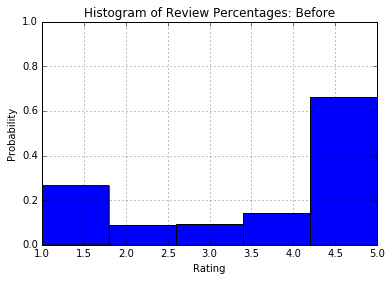

In [29]:
%matplotlib inline

_reviews = []
_reviews.extend([5 for x in reviews_5])
_reviews.extend([4 for x in reviews_4])
_reviews.extend([3 for x in reviews_3])
_reviews.extend([2 for x in reviews_2])
_reviews.extend([1 for x in reviews_1])

# the histogram of the data
n, bins, patches = plt.hist(_reviews, bins=5, normed=True, stacked=True)

plt.xlabel('Rating')
plt.ylabel('Probability')
plt.title('Histogram of Review Percentages: Before')
plt.axis([1, 5, 0, 1])
plt.grid(True)

plt.show()

There would be 0.446417998816% less 1-star reviews


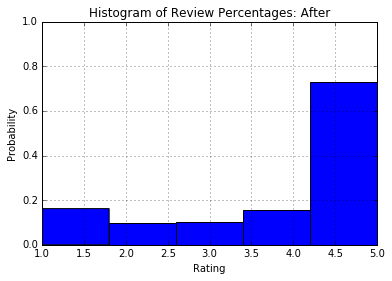

In [30]:
%matplotlib inline

unlimited_reviews_1 = np.array([review['content'] for review in reviews_1[:]])

bad_words = [
    'crash', 
    'fix', 
    'broken', 
    'update', 
    'crash', 
    'slow', 
    'performance', 
    'bug', 
    'load', 
    'fail', 
    'lag'
]

def is_bad(review):
    for b in bad_words:
        if b in review:
            return False
    return True

filtered_bad_reviews = filter(is_bad, unlimited_reviews_1)
difference_percent = 1.0 - (float(len(filtered_bad_reviews)) / float(len(unlimited_reviews_1)))
print("There would be {}% less 1-star reviews".format(difference_percent))

_reviews = []
_reviews.extend([5 for x in reviews_5])
_reviews.extend([4 for x in reviews_4])
_reviews.extend([3 for x in reviews_3])
_reviews.extend([2 for x in reviews_2])
_reviews.extend([1 for x in filtered_bad_reviews])

# the histogram of the data
n, bins, patches = plt.hist(_reviews, bins=5, normed=True, stacked=True)

plt.xlabel('Rating')
plt.ylabel('Probability')
plt.title('Histogram of Review Percentages: After')
plt.axis([1, 5, 0, 1])
plt.grid(True)

plt.show()